# Amazon Review Sentiment Analysis-LSTM MODEL

In [6]:
# Import Necessary Libraries
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit-learn for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score
)

# NLTK for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D, Bidirectional, LSTM,
    GlobalMaxPooling1D, Dense, Dropout
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Load the Dataset into a DataFrame

In [5]:
#Load data
# Set random seed for reproducibility
np.random.seed(42)

# Load Data
def get_labels_and_texts(file, num_samples=None):
    labels = []
    texts = []
    with open(file, "r", encoding='utf-8') as f:  # Open in text mode with utf-8 encoding
        for i, line in enumerate(f):
            if num_samples is not None and i >= num_samples:
                break
            x = line.split(" ", 1)  # Split line into label and text
            labels.append(int(x[0].split("__label__")[1]) - 1)
            texts.append(x[1].strip())
    return np.array(labels), texts

train_labels, train_texts = get_labels_and_texts("Dataset/train.ft.txt", num_samples=3600000)
test_labels, test_texts = get_labels_and_texts("Dataset/test.ft.txt", num_samples=400000)

# Create pandas DataFrame
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})


# Clean and Preprocess the Data

In [3]:
#Cleaning
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts    
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [4]:
# Tokenize texts
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [5]:
# Padding
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH, padding='post')
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH, padding='post')

# Define the model architecture 

In [6]:
# LSTM Model definition
max_seq_length = MAX_LENGTH
vocab_size = 12000
embedding_dim = 128
lstm_units = 128
dropout_rate = 0.1  
inputs = Input(shape=(max_seq_length,), name='input_layer')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length, name='embedding_layer')(inputs)
spatial_dropout = SpatialDropout1D(dropout_rate, name='spatial_dropout')(embedding)
lstm = Bidirectional(LSTM(lstm_units, return_sequences=True), name='bidirectional_lstm')(spatial_dropout)
pooling = GlobalMaxPooling1D(name='global_max_pooling')(lstm)
dense = Dense(128, activation='relu', name='dense')(pooling)
dropout = Dropout(dropout_rate, name='dropout')(dense)
outputs = Dense(1, activation='sigmoid', name='output_layer')(dropout)
model = Model(inputs=inputs, outputs=outputs, name='custom_model')
optimizer = RMSprop()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
print(model.summary())

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 255)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 255, 128)         1536000   
                                                                 
 spatial_dropout (SpatialDro  (None, 255, 128)         0         
 pout1D)                                                         
                                                                 
 bidirectional_lstm (Bidirec  (None, 255, 256)         263168    
 tional)                                                         
                                                                 
 global_max_pooling (GlobalM  (None, 256)              0         
 axPooling1D)                                                    
                                                      

# Train the Model

In [30]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

Epoch 1/60
22500/22500 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.8915 - precision_1: 0.8979 - recall_1: 0.8834

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1323s 59ms/step - loss: 0.2607 - accuracy: 0.8915 - precision_1: 0.8979 - recall_1: 0.8834 - val_loss: 0.1965 - val_accuracy: 0.9227 - val_precision_1: 0.9295 - val_recall_1: 0.9149
Epoch 2/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9261 - precision_1: 0.9282 - recall_1: 0.9236

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1322s 59ms/step - loss: 0.1899 - accuracy: 0.9261 - precision_1: 0.9282 - recall_1: 0.9236 - val_loss: 0.1813 - val_accuracy: 0.9296 - val_precision_1: 0.9489 - val_recall_1: 0.9082
Epoch 3/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9331 - precision_1: 0.9349 - recall_1: 0.9310

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1340s 60ms/step - loss: 0.1745 - accuracy: 0.9331 - precision_1: 0.9349 - recall_1: 0.9310 - val_loss: 0.1683 - val_accuracy: 0.9359 - val_precision_1: 0.9318 - val_recall_1: 0.9407
Epoch 4/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9370 - precision_1: 0.9386 - recall_1: 0.9352

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1326s 59ms/step - loss: 0.1655 - accuracy: 0.9370 - precision_1: 0.9386 - recall_1: 0.9352 - val_loss: 0.1600 - val_accuracy: 0.9390 - val_precision_1: 0.9491 - val_recall_1: 0.9279
Epoch 5/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9397 - precision_1: 0.9410 - recall_1: 0.9382

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1329s 59ms/step - loss: 0.1593 - accuracy: 0.9397 - precision_1: 0.9410 - recall_1: 0.9382 - val_loss: 0.1543 - val_accuracy: 0.9415 - val_precision_1: 0.9410 - val_recall_1: 0.9423
Epoch 6/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9418 - precision_1: 0.9429 - recall_1: 0.9404

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1320s 59ms/step - loss: 0.1545 - accuracy: 0.9418 - precision_1: 0.9429 - recall_1: 0.9404 - val_loss: 0.1537 - val_accuracy: 0.9420 - val_precision_1: 0.9554 - val_recall_1: 0.9274
Epoch 7/60
22499/22500 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9435 - precision_1: 0.9447 - recall_1: 0.9422

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1327s 59ms/step - loss: 0.1507 - accuracy: 0.9435 - precision_1: 0.9447 - recall_1: 0.9422 - val_loss: 0.1504 - val_accuracy: 0.9433 - val_precision_1: 0.9564 - val_recall_1: 0.9290
Epoch 8/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9450 - precision_1: 0.9461 - recall_1: 0.9438

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1332s 59ms/step - loss: 0.1473 - accuracy: 0.9450 - precision_1: 0.9461 - recall_1: 0.9438 - val_loss: 0.1447 - val_accuracy: 0.9457 - val_precision_1: 0.9502 - val_recall_1: 0.9408
Epoch 9/60
22499/22500 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9463 - precision_1: 0.9473 - recall_1: 0.9452

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1328s 59ms/step - loss: 0.1444 - accuracy: 0.9463 - precision_1: 0.9473 - recall_1: 0.9452 - val_loss: 0.1428 - val_accuracy: 0.9465 - val_precision_1: 0.9512 - val_recall_1: 0.9414
Epoch 10/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9473 - precision_1: 0.9483 - recall_1: 0.9462

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1323s 59ms/step - loss: 0.1420 - accuracy: 0.9473 - precision_1: 0.9483 - recall_1: 0.9462 - val_loss: 0.1405 - val_accuracy: 0.9477 - val_precision_1: 0.9494 - val_recall_1: 0.9458
Epoch 11/60
22500/22500 [==============================] - 1311s 58ms/step - loss: 0.1398 - accuracy: 0.9482 - precision_1: 0.9491 - recall_1: 0.9472 - val_loss: 0.1461 - val_accuracy: 0.9451 - val_precision_1: 0.9304 - val_recall_1: 0.9623
Epoch 12/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9490 - precision_1: 0.9499 - recall_1: 0.9480

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1330s 59ms/step - loss: 0.1380 - accuracy: 0.9490 - precision_1: 0.9499 - recall_1: 0.9480 - val_loss: 0.1393 - val_accuracy: 0.9480 - val_precision_1: 0.9421 - val_recall_1: 0.9547
Epoch 13/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9497 - precision_1: 0.9505 - recall_1: 0.9487

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1338s 59ms/step - loss: 0.1364 - accuracy: 0.9497 - precision_1: 0.9505 - recall_1: 0.9487 - val_loss: 0.1378 - val_accuracy: 0.9487 - val_precision_1: 0.9572 - val_recall_1: 0.9395
Epoch 14/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9503 - precision_1: 0.9512 - recall_1: 0.9494

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1336s 59ms/step - loss: 0.1349 - accuracy: 0.9503 - precision_1: 0.9512 - recall_1: 0.9494 - val_loss: 0.1355 - val_accuracy: 0.9498 - val_precision_1: 0.9558 - val_recall_1: 0.9433
Epoch 15/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9509 - precision_1: 0.9517 - recall_1: 0.9500

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1349s 60ms/step - loss: 0.1334 - accuracy: 0.9509 - precision_1: 0.9517 - recall_1: 0.9500 - val_loss: 0.1353 - val_accuracy: 0.9499 - val_precision_1: 0.9575 - val_recall_1: 0.9417
Epoch 16/60
22500/22500 [==============================] - 1337s 59ms/step - loss: 0.1323 - accuracy: 0.9515 - precision_1: 0.9521 - recall_1: 0.9508 - val_loss: 0.1353 - val_accuracy: 0.9500 - val_precision_1: 0.9446 - val_recall_1: 0.9562
Epoch 17/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9520 - precision_1: 0.9527 - recall_1: 0.9512

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1352s 60ms/step - loss: 0.1311 - accuracy: 0.9520 - precision_1: 0.9527 - recall_1: 0.9512 - val_loss: 0.1335 - val_accuracy: 0.9507 - val_precision_1: 0.9561 - val_recall_1: 0.9450
Epoch 18/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9525 - precision_1: 0.9532 - recall_1: 0.9518

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1351s 60ms/step - loss: 0.1301 - accuracy: 0.9525 - precision_1: 0.9532 - recall_1: 0.9518 - val_loss: 0.1327 - val_accuracy: 0.9510 - val_precision_1: 0.9464 - val_recall_1: 0.9562
Epoch 19/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9529 - precision_1: 0.9534 - recall_1: 0.9522

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1359s 60ms/step - loss: 0.1291 - accuracy: 0.9529 - precision_1: 0.9534 - recall_1: 0.9522 - val_loss: 0.1322 - val_accuracy: 0.9511 - val_precision_1: 0.9586 - val_recall_1: 0.9429
Epoch 20/60
22500/22500 [==============================] - 1347s 60ms/step - loss: 0.1281 - accuracy: 0.9534 - precision_1: 0.9540 - recall_1: 0.9526 - val_loss: 0.1331 - val_accuracy: 0.9509 - val_precision_1: 0.9616 - val_recall_1: 0.9393
Epoch 21/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9537 - precision_1: 0.9542 - recall_1: 0.9531

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1364s 61ms/step - loss: 0.1273 - accuracy: 0.9537 - precision_1: 0.9542 - recall_1: 0.9531 - val_loss: 0.1308 - val_accuracy: 0.9520 - val_precision_1: 0.9548 - val_recall_1: 0.9491
Epoch 22/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.9540 - precision_1: 0.9546 - recall_1: 0.9533

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1364s 61ms/step - loss: 0.1265 - accuracy: 0.9540 - precision_1: 0.9546 - recall_1: 0.9533 - val_loss: 0.1297 - val_accuracy: 0.9523 - val_precision_1: 0.9541 - val_recall_1: 0.9503
Epoch 23/60
22499/22500 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9543 - precision_1: 0.9549 - recall_1: 0.9537

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1345s 60ms/step - loss: 0.1257 - accuracy: 0.9543 - precision_1: 0.9549 - recall_1: 0.9537 - val_loss: 0.1289 - val_accuracy: 0.9525 - val_precision_1: 0.9540 - val_recall_1: 0.9509
Epoch 24/60
22500/22500 [==============================] - 1337s 59ms/step - loss: 0.1250 - accuracy: 0.9547 - precision_1: 0.9553 - recall_1: 0.9540 - val_loss: 0.1313 - val_accuracy: 0.9516 - val_precision_1: 0.9617 - val_recall_1: 0.9408
Epoch 25/60
22500/22500 [==============================] - 1335s 59ms/step - loss: 0.1243 - accuracy: 0.9549 - precision_1: 0.9555 - recall_1: 0.9543 - val_loss: 0.1290 - val_accuracy: 0.9529 - val_precision_1: 0.9511 - val_recall_1: 0.9550
Epoch 26/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9553 - precision_1: 0.9558 - recall_1: 0.9547

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1355s 60ms/step - loss: 0.1236 - accuracy: 0.9553 - precision_1: 0.9558 - recall_1: 0.9547 - val_loss: 0.1281 - val_accuracy: 0.9529 - val_precision_1: 0.9570 - val_recall_1: 0.9486
Epoch 27/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9554 - precision_1: 0.9559 - recall_1: 0.9549

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1354s 60ms/step - loss: 0.1230 - accuracy: 0.9554 - precision_1: 0.9559 - recall_1: 0.9549 - val_loss: 0.1276 - val_accuracy: 0.9531 - val_precision_1: 0.9505 - val_recall_1: 0.9561
Epoch 28/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9557 - precision_1: 0.9562 - recall_1: 0.9552

INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model5-3mdata_fbest_model\assets


22500/22500 [==============================] - 1340s 60ms/step - loss: 0.1225 - accuracy: 0.9557 - precision_1: 0.9562 - recall_1: 0.9552 - val_loss: 0.1274 - val_accuracy: 0.9533 - val_precision_1: 0.9573 - val_recall_1: 0.9489
Epoch 29/60
22500/22500 [==============================] - 1331s 59ms/step - loss: 0.1218 - accuracy: 0.9560 - precision_1: 0.9565 - recall_1: 0.9555 - val_loss: 0.1280 - val_accuracy: 0.9532 - val_precision_1: 0.9587 - val_recall_1: 0.9473
Epoch 30/60
22500/22500 [==============================] - 1327s 59ms/step - loss: 0.1213 - accuracy: 0.9563 - precision_1: 0.9568 - recall_1: 0.9557 - val_loss: 0.1282 - val_accuracy: 0.9529 - val_precision_1: 0.9607 - val_recall_1: 0.9444
Epoch 31/60
22500/22500 [==============================] - 1323s 59ms/step - loss: 0.1207 - accuracy: 0.9564 - precision_1: 0.9570 - recall_1: 0.9558 - val_loss: 0.1277 - val_accuracy: 0.9533 - val_precision_1: 0.9590 - val_recall_1: 0.9472


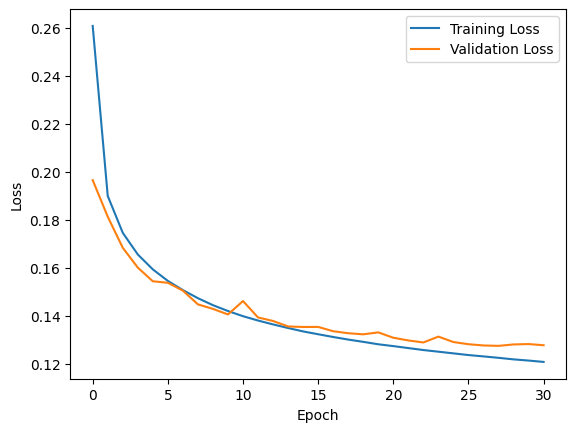

In [32]:
# Training of the model
optimizer = RMSprop(learning_rate=0.000025)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Model5-3mdata_fbest_model', monitor='val_loss', save_best_only=True)
history = model.fit(X_train, y_train, epochs=60, batch_size=128, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint], verbose=1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Model5-3mdata_loss_curve.png')
plt.show()

# Model Evaluation with Metrics

22500/22500 [==============================] - 410s 18ms/step
Validation Accuracy: 0.9533
Precision: 0.9573
Recall: 0.9489
F1 Score: 0.9531
Sensitivity: 0.9489


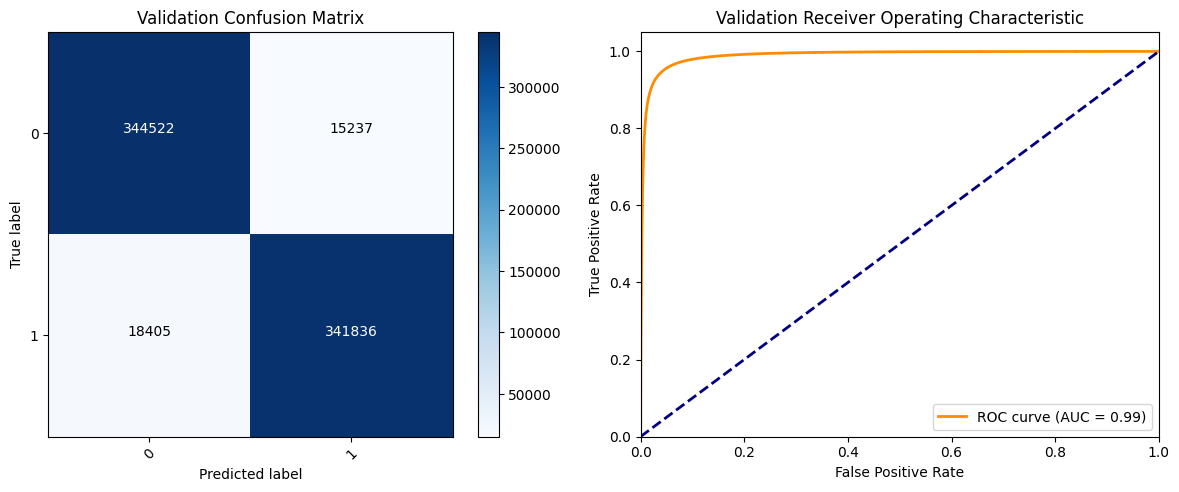

In [33]:
val_predictions = model.predict(X_val)
val_predictions_prob_positive = val_predictions[:, 0] 
val_predictions_binary = np.where(val_predictions_prob_positive > 0.5, 1, 0)
conf_matrix_val = confusion_matrix(y_val, val_predictions_binary)
fpr_val, tpr_val, _ = roc_curve(y_val, val_predictions_prob_positive)
roc_auc_val = auc(fpr_val, tpr_val)
precision_val, recall_val, _ = precision_recall_curve(y_val, val_predictions_prob_positive)
pr_auc_val = average_precision_score(y_val, val_predictions_prob_positive)
accuracy_val = accuracy_score(y_val, val_predictions_binary)
precision_val = precision_score(y_val, val_predictions_binary)
recall_val = recall_score(y_val, val_predictions_binary)
f1_val = f1_score(y_val, val_predictions_binary)
sensitivity_val = recall_val
print(f'Validation Accuracy: {accuracy_val:.4f}')
print(f'Precision: {precision_val:.4f}')
print(f'Recall: {recall_val:.4f}')
print(f'F1 Score: {f1_val:.4f}')
print(f'Sensitivity: {sensitivity_val:.4f}')
plt.figure(figsize=(12, 5))
classes = ['0', '1']  
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_val, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(classes)), classes, rotation=45)  
plt.yticks(np.arange(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix_val[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_val[i, j] > conf_matrix_val.max() / 2 else "black")
plt.subplot(1, 2, 2)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Model5-3mdata_validation_metrics.png')
plt.show()

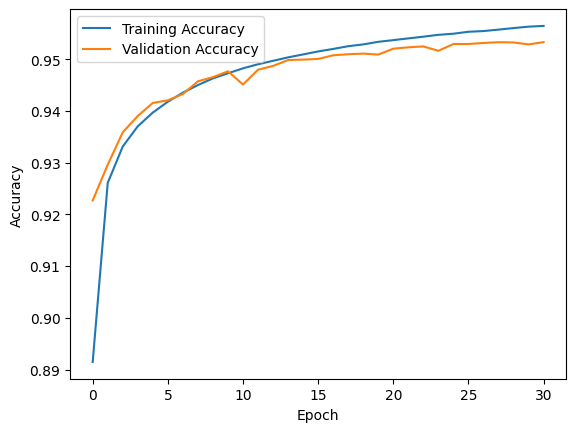

In [34]:
# Plot accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Model5-3mdata_accuracy_curve.png')
plt.show()
